# Laminar flow in finite difference 

In [5]:
%reset -f

import os, sys
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from _utils import plot

  0%|          | 0/5000 [00:00<?, ?it/s]

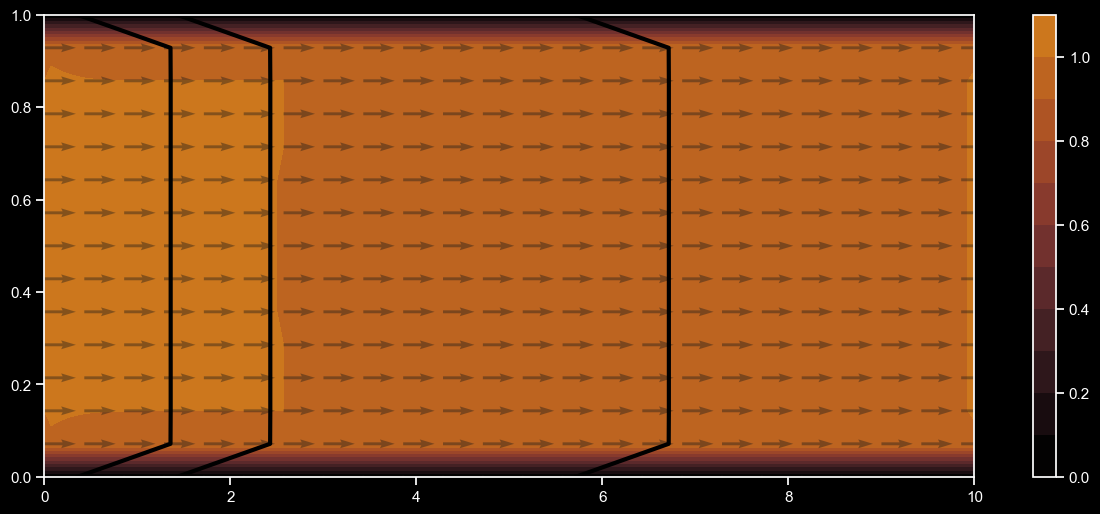

  8%|▊         | 378/5000 [00:00<00:04, 1008.13it/s]

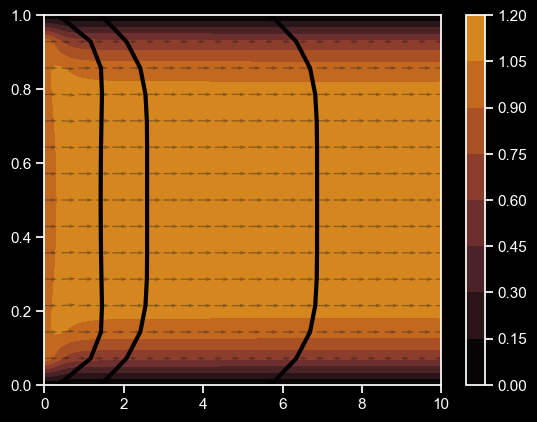

 18%|█▊        | 882/5000 [00:01<00:03, 1058.26it/s]

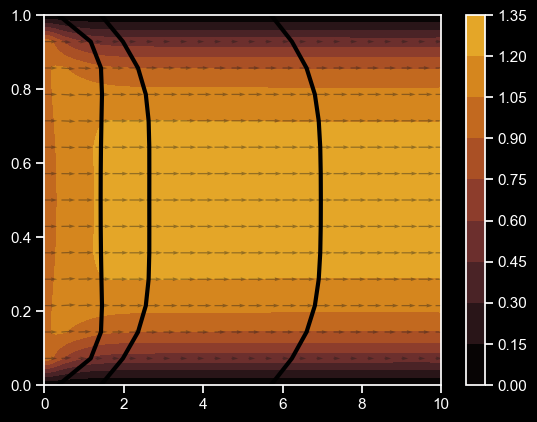

 28%|██▊       | 1383/5000 [00:01<00:03, 1067.40it/s]

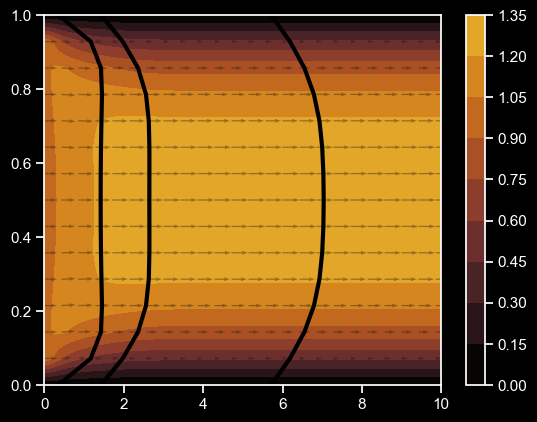

 38%|███▊      | 1881/5000 [00:02<00:02, 1062.94it/s]

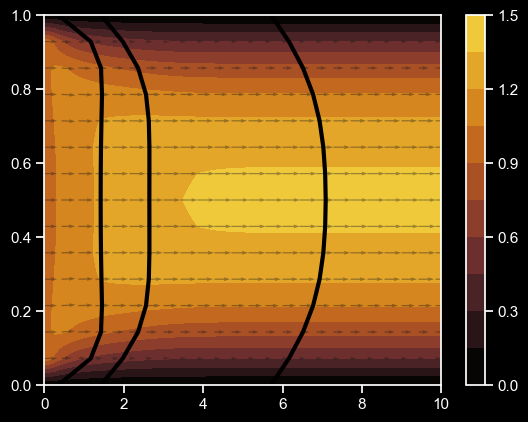

 48%|████▊     | 2380/5000 [00:02<00:02, 1069.96it/s]

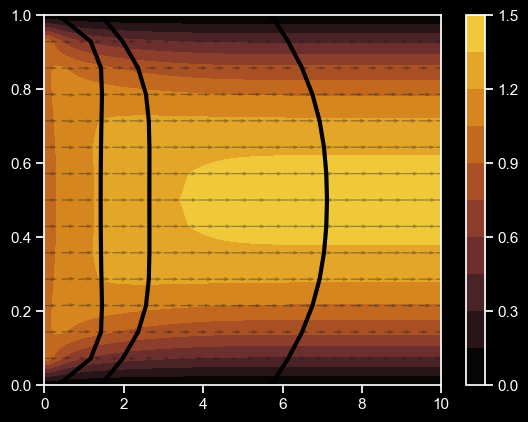

 58%|█████▊    | 2885/5000 [00:03<00:01, 1080.83it/s]

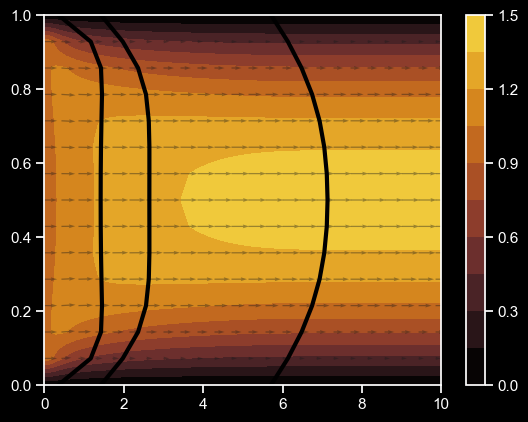

 68%|██████▊   | 3387/5000 [00:03<00:01, 1080.34it/s]

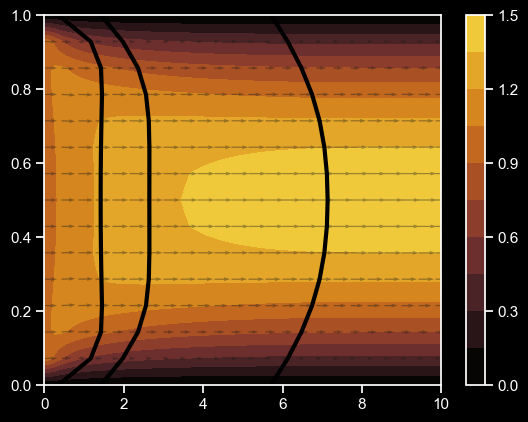

 78%|███████▊  | 3888/5000 [00:04<00:01, 1076.78it/s]

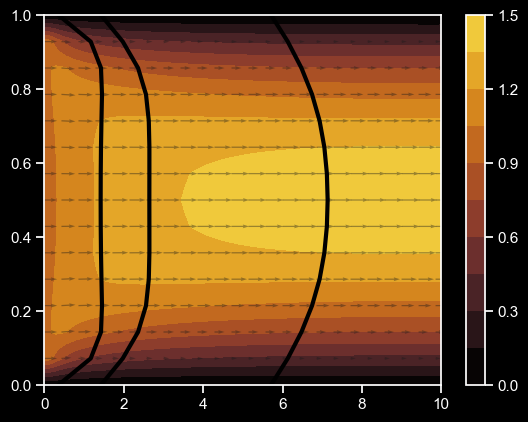

 88%|████████▊ | 4396/5000 [00:04<00:00, 1039.62it/s]

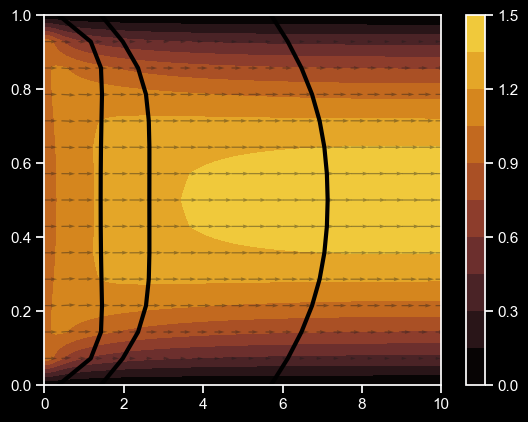

100%|██████████| 5000/5000 [00:05<00:00, 926.21it/s] 


<Figure size 640x480 with 0 Axes>

In [6]:
"""
Solves the equation of fluid motion in a pipe with inlet and outlet.
This will simulate the inflow behavior into the pipe and the
boundary layer developing over time and space. The system of equations
is solved using a Staggered Grid, Finite Differences (almost Finite
Volume), explicit Euler time-stepping and a P2 pressure correction
scheme (very similar to the SIMPLE algorithm) based on a segregated
approach.


Momentum:           ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f

Incompressibility:  ∇ ⋅ u = 0


u:  Velocity (2d vector)
p:  Pressure
f:  Forcing (here =0)
ν:  Kinematic Viscosity
ρ:  Density
t:  Time
∇:  Nabla operator (defining nonlinear convection, gradient and divergence)
∇²: Laplace Operator

--------

Scenario


                        wall: u=0, v=0
        +-----------------------------------------------+
        |  -->      -->       -->        -->      -->   |
inflow  |                                               | outflow
u = 1   |  -->      -->       -->        -->      -->   | ∂u/∂x = 0
v = 0   |                                               | ∂v/∂x = 0
        |  -->      -->       -->        -->      -->   |
        +-----------------------------------------------+
                        wall: u=0, v=0                       

-> A rectangular domain (think of a slice from a pipe with
   circular cross-section alongside the longitudinal axis)
-> Top and bottom edge represent wall boundary conditions
-> A uniform inflow profile (over the pipe's cross section)
   is prescribed at the left edge - a 1.0 horizontal
   velocity and a 0.0 vertical velocity
-> The right edge represents an outflow, defined by the
   assumption that the flow does not change anymore over
   the horizontal axis, hence the normal derivatives of
   both velocity components are zero
-> Initially, the u velocity is uniform 1.0 over the domain,
   the v velocity is uniform 0.0

--------

Expected Outcome

        +-----------------------------------------------+
        |   -->      -->      ->       >        >       |
        |   -->      -->      --->     --->     --->    |
        |   -->      --->     --->     ---->    ---->   |
        |   -->      -->      --->     --->     --->    |
        |   -->      -->      ->       >        >       |
        +-----------------------------------------------+

The flow is developing the characteristic parabolic Hagen-Poiseulle
profile at some point x in the domain and will keep this profile
until the outflow on the right

-------

A (classical) co-located grid

        + - - - + - - - + - - - + - - - + - - - + - - - +
        |       |       |       |       |       |       |
        |       |       |       |       |       |       |
        |       |       |       |       |       |       |
        + - - - + - - - + - - - + - - - + - - - + - - - +
        |       |       |       |       |       |       |
        |       |       |       |       |       |       |
        |       |       |       |       |       |       |
        + - - - + - - - + - - - + - - - + - - - + - - - +
        |       |       |       |       |       |       |
        |       |       |       |       |       |       |
        |       |       |       |       |       |       |
        0 - - - + - - - + - - - + - - - + - - - + - - - +

All variables (u-velocity, v-velocity, pressure) are saved
at the mesh vertices ("+").

-> Using central differences for pressure gradient and divergence
results in checkerboard pattern - problematic here.

-------

Remedy: The staggered grid

        + - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - +
        |       |       |       |       |       |       |
        →   •   →   •   →   •   →   •   →   •   →   •   →
        |       |       |       |       |       |       |
        + - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - +
        |       |       |       |       |       |       |
        →   •   →   •   →   •   →   •   →   •   →   •   →
        |       |       |       |       |       |       |
        + - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - +
        |       |       |       |       |       |       |
        →   •   →   •   →   •   →   •   →   •   →   •   →
        |       |       |       |       |       |       |
        0 - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - +

The pressure is saved at "•"
The horizontal velocity is saved at "→"
The vertical velocity is saved at "↑"

If the "0" indicates the origin of the domain, then

* u-velocities are staggered in y direction
* v-velocities are staggered in x direction
* pressure is staggered in both x and y direction

If we have N_x vertex nodes in x direction and N_y vertex nodes
in y direction, then:

* u_velocities use (N_y - 1) by N_x nodes
* v_velocities use N_y by (N_x - 1) nodes
* pressure use (N_y - 1) by (N_x - 1) nodes

-----

The staggered grid with ghost cells

        |       |       |       |       |       |       |    
    •   →   •   →   •   →   •   →   •   →   •   →   •   →   •
    ↑ - ❖---↑---❖---↑---❖---↑---❖---↑---❖---↑---❖---↑---❖ - ↑
        |       |       |       |       |       |       |    
    •   →   •   →   •   →   •   →   •   →   •   →   •   →   •
        |       |       |       |       |       |       |    
    ↑ - ❖ - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - ❖ - ↑
        |       |       |       |       |       |       |    
    •   →   •   →   •   →   •   →   •   →   •   →   •   →   •
        |       |       |       |       |       |       |    
    ↑ - ❖ - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - + - ↑ - ❖ - ↑
        |       |       |       |       |       |       |    
    •   →   •   →   •   →   •   →   •   →   •   →   •   →   •
        |       |       |       |       |       |       |    
    ↑ - 0---↑---❖---↑---❖---↑---❖---↑---❖---↑---❖---↑---❖ - ↑
        |       |       |       |       |       |       |    
    •   →   •   →   •   →   •   →   •   →   •   →   •   →   •


Add one padding layer of pressure nodes around the domain
together with its corresponding staggered velocities.

"❖" denotes grid vertices that are on the boundary. Everything
outside of it, is called a ghost node. We need it to enforce the
boundary condition.

Again, if we have N_x vertex nodes in x direction and N_y vertex nodes
in y direction, then (including the ghost nodes):

* u_velocities use (N_y + 1) by N_x nodes
* v_velocities use N_y by (N_x + 1) nodes
* pressure use (N_y + 1) by (N_x + 1) nodes

IMPORTANT: When taking derivatives make sure in which staggered
grid you are thinking.

-----

Solution Strategy:

Usage of a P2 pressure correction scheme (very similar to the SIMPLE
algorithm)

0. Initialization

    0.1 Initialize the u velocity uniformly with ones (+ wall boundaries)

    0.2 Initialize the v velocity uniformly with zeros

    0.3 Initialize the p (=pressure) uniformly with zeros

1. Update the u velocities (+ Boundary Conditions)

    u ← u + dt ⋅ (− ∂p/∂x + ν ∇²u − ∂u²/∂x − v ∂u/∂y)

2. Update the v velocities (+ Boundary Conditions)

    v ← v + dt ⋅ (− ∂p/∂y + ν ∇²v − u ∂v/∂x − ∂v²/∂y)

3. Compute the divergence of the tentative velocity components

    d = ∂u/∂x + ∂v/∂y

4. Solve a Poisson problem for the pressure correction q
   (this problem has homogeneous Neumann BC everywhere except
   for the right edge of the domain (the outlet))

    solve   ∇²q = d / dt   for  q

5. Update the pressure

    p ← p + q

6. Update the velocities to be incompressible

    u ← u − dt ⋅ ∂q/∂x

    v ← v − dt ⋅ ∂q/∂y

7. Repeat time loop until steady-state is reached


For visualizations the velocities have to mapped to the
original vertex-centered grid.

The flow might require a correction at the outlet to ensure
continuity over the entire domain.

The density is assumed to be 1.0

-----

Notes on stability:

1. We are using an explicit diffusion treatment (FTCS) which
   has the stability condition:

   (ν dt) / (dx²) ≤ 1/2

2. We are using a central difference approximation for the
   convection term which is only stable if the diffusive
   transport is dominant (i.e., do not select the kinematic
   viscosity too low).

3. The Pressure Poisson (correction) problem is solved using
   Jacobi smoothing. This is sufficient for this simple
   application, but due to the fixed number of iterations
   does not ensure the residual is sufficiently small. That 
   could introduce local compressibility.
"""

import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

N_POINTS_Y = 15
ASPECT_RATIO = 10
KINEMATIC_VISCOSITY = 0.01
TIME_STEP_LENGTH = 0.001
N_TIME_STEPS = 5000
PLOT_EVERY = 500

N_PRESSURE_POISSON_ITERATIONS = 50

def main():
    cell_length = 1.0 / (N_POINTS_Y - 1)

    n_points_x = (N_POINTS_Y - 1) * ASPECT_RATIO + 1

    x_range = np.linspace(0.0, 1.0 * ASPECT_RATIO, n_points_x)
    y_range = np.linspace(0.0, 1.0, N_POINTS_Y)

    coordinates_x, coordinates_y = np.meshgrid(x_range, y_range)

    # Initial condition
    velocity_x_prev = np.ones((N_POINTS_Y + 1, n_points_x))
    velocity_x_prev[0, :] = - velocity_x_prev[1, :]
    velocity_x_prev[-1, :] = - velocity_x_prev[-2, :]

    velocity_y_prev = np.zeros((N_POINTS_Y, n_points_x+1))

    pressure_prev = np.zeros((N_POINTS_Y+1, n_points_x+1))

    # Pre-Allocate some arrays
    velocity_x_tent = np.zeros_like(velocity_x_prev)
    velocity_x_next = np.zeros_like(velocity_x_prev)

    velocity_y_tent = np.zeros_like(velocity_y_prev)
    velocity_y_next = np.zeros_like(velocity_y_prev)

    plt.style.use("dark_background")
    plt.figure(figsize=(1.5*ASPECT_RATIO, 6))

    for iter in tqdm(range(N_TIME_STEPS)):
        # Update interior of u velocity
        diffusion_x = KINEMATIC_VISCOSITY * (
            (
                +
                velocity_x_prev[1:-1, 2:  ]
                +
                velocity_x_prev[2:  , 1:-1]
                +
                velocity_x_prev[1:-1,  :-2]
                +
                velocity_x_prev[ :-2, 1:-1]
                - 4 *
                velocity_x_prev[1:-1, 1:-1]
            ) / (
                cell_length**2
            )
        )
        convection_x = (
            (
                velocity_x_prev[1:-1, 2:  ]**2
                -
                velocity_x_prev[1:-1,  :-2]**2
            ) / (
                2 * cell_length
            )
            +
            (
                velocity_y_prev[1:  , 1:-2]
                +
                velocity_y_prev[1:  , 2:-1]
                +
                velocity_y_prev[ :-1, 1:-2]
                +
                velocity_y_prev[ :-1, 2:-1]
            ) / 4
            *
            (
                velocity_x_prev[2:  , 1:-1]
                -
                velocity_x_prev[ :-2, 1:-1]
            ) / (
                2 * cell_length
            )
        )
        pressure_gradient_x = (
            (
                pressure_prev[1:-1, 2:-1]
                -
                pressure_prev[1:-1, 1:-2]
            ) / (
                cell_length
            )
        )

        velocity_x_tent[1:-1, 1:-1] = (
            velocity_x_prev[1:-1, 1:-1]
            +
            TIME_STEP_LENGTH
            *
            (
                -
                pressure_gradient_x
                +
                diffusion_x
                -
                convection_x
            )
        )

        # Apply BC
        velocity_x_tent[1:-1, 0] = 1.0
        velocity_x_tent[1:-1, -1] = velocity_x_tent[1:-1, -2]
        velocity_x_tent[0, :] = - velocity_x_tent[1, :]
        velocity_x_tent[-1, :] = - velocity_x_tent[-2, :]

        # Update interior of v velocity
        diffusion_y = KINEMATIC_VISCOSITY * (
            (
                +
                velocity_y_prev[1:-1, 2:  ]
                +
                velocity_y_prev[2:  , 1:-1]
                +
                velocity_y_prev[1:-1,  :-2]
                +
                velocity_y_prev[ :-2, 1:-1]
                -
                4 * velocity_y_prev[1:-1, 1:-1]
            ) / (
                cell_length**2
            )
        )
        convection_y = (
            (
                velocity_x_prev[2:-1, 1:  ]
                +
                velocity_x_prev[2:-1,  :-1]
                +
                velocity_x_prev[1:-2, 1:  ]
                +
                velocity_x_prev[1:-2,  :-1]
            ) / 4
            *
            (
                velocity_y_prev[1:-1, 2:  ]
                -
                velocity_y_prev[1:-1,  :-2]
            ) / (
                2 * cell_length
            )
            +
            (
                velocity_y_prev[2:  , 1:-1]**2
                -
                velocity_y_prev[ :-2, 1:-1]**2
            ) / (
                2 * cell_length
            )
        )
        pressure_gradient_y = (
            (
                pressure_prev[2:-1, 1:-1]
                -
                pressure_prev[1:-2, 1:-1]
            ) / (
                cell_length
            )
        )

        velocity_y_tent[1:-1, 1:-1] = (
            velocity_y_prev[1:-1, 1:-1]
            +
            TIME_STEP_LENGTH
            *
            (
                -
                pressure_gradient_y
                +
                diffusion_y
                -
                convection_y
            )
        )

        # Apply BC
        velocity_y_tent[1:-1, 0] = - velocity_y_tent[1:-1, 1]
        velocity_y_tent[1:-1, -1] = velocity_y_tent[1:-1, -2]
        velocity_y_tent[0, :] = 0.0
        velocity_y_tent[-1, :] = 0.0

        # Compute the divergence as it will be the rhs of the pressure poisson
        # problem
        divergence = (
            (
                velocity_x_tent[1:-1, 1:  ]
                -
                velocity_x_tent[1:-1,  :-1]
            ) / (
                cell_length
            )
            +
            (
                velocity_y_tent[1:  , 1:-1]
                -
                velocity_y_tent[ :-1, 1:-1]
            ) / (
                cell_length
            )
        )
        pressure_poisson_rhs = divergence / TIME_STEP_LENGTH

        # Solve the pressure correction poisson problem
        pressure_correction_prev = np.zeros_like(pressure_prev)
        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            pressure_correction_next = np.zeros_like(pressure_correction_prev)
            pressure_correction_next[1:-1, 1:-1] = 1/4 * (
                +
                pressure_correction_prev[1:-1, 2:  ]
                +
                pressure_correction_prev[2:  , 1:-1]
                +
                pressure_correction_prev[1:-1,  :-2]
                +
                pressure_correction_prev[ :-2, 1:-1]
                -
                cell_length**2
                *
                pressure_poisson_rhs
            )

            # Apply pressure BC: Homogeneous Neumann everywhere except for the
            # right where is a homogeneous Dirichlet
            pressure_correction_next[1:-1, 0] = pressure_correction_next[1:-1, 1]
            pressure_correction_next[1:-1, -1] = - pressure_correction_next[1:-1, -2]
            pressure_correction_next[0, :] = pressure_correction_next[1, :]
            pressure_correction_next[-1, :] = pressure_correction_next[-2, :]

            # Advance in smoothing
            pressure_correction_prev = pressure_correction_next
        
        # Update the pressure
        pressure_next = pressure_prev + pressure_correction_next

        # Correct the velocities to be incompressible
        pressure_correction_gradient_x = (
            (
                pressure_correction_next[1:-1, 2:-1]
                -
                pressure_correction_next[1:-1, 1:-2]
            ) / (
                cell_length
            )
        )

        velocity_x_next[1:-1, 1:-1] = (
            velocity_x_tent[1:-1, 1:-1]
            -
            TIME_STEP_LENGTH
            *
            pressure_correction_gradient_x
        )

        pressure_correction_gradient_y = (
            (
                pressure_correction_next[2:-1, 1:-1]
                -
                pressure_correction_next[1:-2, 1:-1]
            ) / (
                cell_length
            )
        )

        velocity_y_next[1:-1, 1:-1] = (
            velocity_y_tent[1:-1, 1:-1]
            -
            TIME_STEP_LENGTH
            *
            pressure_correction_gradient_y
        )

        # Again enforce BC
        velocity_x_next[1:-1, 0] = 1.0
        inflow_mass_rate_next = np.sum(velocity_x_next[1:-1, 0])
        outflow_mass_rate_next = np.sum(velocity_x_next[1:-1, -2])
        velocity_x_next[1:-1, -1] = velocity_x_next[1:-1, -2] * inflow_mass_rate_next / outflow_mass_rate_next
        velocity_x_next[0, :] = - velocity_x_next[1, :]
        velocity_x_next[-1, :] = - velocity_x_next[-2, :]

        velocity_y_next[1:-1, 0] = - velocity_y_next[1:-1, 1]
        velocity_y_next[1:-1, -1] = velocity_y_next[1:-1, -2]
        velocity_y_next[0, :] = 0.0
        velocity_y_next[-1, :] = 0.0

        # Advance in time
        velocity_x_prev = velocity_x_next
        velocity_y_prev = velocity_y_next
        pressure_prev = pressure_next

        # inflow_mass_rate_next = np.sum(velocity_x_next[1:-1, 0])
        # outflow_mass_rate_next = np.sum(velocity_x_next[1:-1, -1])
        # print(f"Inflow: {inflow_mass_rate_next}")
        # print(f"Outflow: {outflow_mass_rate_next}")
        # print()

        # Visualization
        if iter % PLOT_EVERY == 0:
            velocity_x_vertex_centered = (
                (
                    velocity_x_next[1:  , :]
                    +
                    velocity_x_next[ :-1, :]
                ) / 2
            )
            velocity_y_vertex_centered = (
                (
                    velocity_y_next[:, 1:  ]
                    +
                    velocity_y_next[:,  :-1]
                ) / 2
            )

            plt.contourf(
                coordinates_x,
                coordinates_y,
                velocity_x_vertex_centered,
                levels=10,
                cmap=cmr.amber,
                vmin=0.0,
                vmax=1.6,
            )
            plt.colorbar()

            plt.quiver(
                coordinates_x[:, ::6],
                coordinates_y[:, ::6],
                velocity_x_vertex_centered[:, ::6],
                velocity_y_vertex_centered[:, ::6],
                alpha=0.4,
            )

            plt.plot(
                5 * cell_length + velocity_x_vertex_centered[:, 5],
                coordinates_y[:, 5], 
                color="black",
                linewidth=3,
            )
            plt.plot(
                20 * cell_length + velocity_x_vertex_centered[:, 20],
                coordinates_y[:, 20], 
                color="black",
                linewidth=3,
            )
            plt.plot(
                80 * cell_length + velocity_x_vertex_centered[:, 80],
                coordinates_y[:, 80], 
                color="black",
                linewidth=3,
            )

            plt.draw()
            plt.pause(0.05)
            plt.clf()
    
    plt.show()

if __name__ == "__main__":
    main()


## Findings
